# ML Project Week 14

## Imports

In [1]:
pip install keras-rl

     |████████████████████████████████| 40kB 2.7MB/s 
  Created wheel for keras-rl: filename=keras_rl-0.4.2-cp36-none-any.whl size=48380 sha256=b7e1e7a47c7a2d2697b8b6b66bb0f7bf960f1a83c6b2e84870dd64bf421beee1
  Stored in directory: /root/.cache/pip/wheels/7d/4d/84/9254c9f2e8f51865cb0dac8e79da85330c735551d31f73c894
Successfully built keras-rl


In [2]:
import gym # openAi gym
from gym import envs
import numpy as np 
import datetime
import keras 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd 
from time import sleep

from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor
from rl.callbacks import FileLogger, ModelIntervalCheckpoint
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


# 1. Reinforcement Learning for the Taxi Problem
Used code from: https://www.kaggle.com/angps95/intro-to-reinforcement-learning-withopenai-gym

## Taxi Environment
A Taxi can move, pick up passenger, drop the passenger off<br>
MAP: 
* | and - = Wall, not passable
* Yellow = Taxi location
* Blue = Pick up location
* Purple = Drop off location
* Green = Taxi with passenger on board
* Letters = Locations

In [0]:
env = gym.make('Taxi-v3')
env.reset()
env.render()


+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [0]:
# total number of states in the system
env.observation_space.n

500

Actions (6 in total)

* 0: move south
* 1: move north
* 2: move east
* 3: move west
* 4: pickup passenger
* 5: dropoff passenger

In [0]:
#Total no. of actions
env.action_space.n

6

In [0]:
env.env.s = 122
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [0]:
env.step(1)

(2, -1, False, {'prob': 1.0})

In [0]:
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)


Each timestep, the agent chooses an action, and the environment returns an observation and a reward.

The 4 elements returned are:

* Observation (object): the state the environment is in or an environment-specific object representing your observation of the environment.
* Reward (float): Reward achieved by the previous action.
  * +20: Last step when we successfully pick up a passenger and drop them off at their desired location
  * -1: for each step in order for the agent to try and find the quickest solution possible
  * -10: every time you incorrectly pick up or drop off a passenger
* Done (boolean): whether it’s time to reset the environment again. Most (but not all) tasks are divided up into well-defined episodes, and done being True indicates the episode has terminated. (For example, you lost your last life.)
* Info (dict): Can be ignored, diagnostic information useful for debugging. Official evaluations of your agent are not allowed to use this for learning.

In [0]:
# see the rewards for a specific state for all the actions
env.reset()
env.env.P[245]

{0: [(1.0, 345, -1, False)],
 1: [(1.0, 145, -1, False)],
 2: [(1.0, 265, -1, False)],
 3: [(1.0, 225, -1, False)],
 4: [(1.0, 245, -10, False)],
 5: [(1.0, 245, -10, False)]}

## Random Search

In [0]:
env = gym.make('Taxi-v3')
random_policy = np.ones([env.env.nS, env.env.nA]) / env.env.nA
def random_policy_steps_count():
    state = env.reset()
    counter = 0
    reward = None
    while reward != 20:
        state, reward, done, info = env.step(env.action_space.sample())  
        counter += 1
    return counter

In [6]:
counts = [random_policy_steps_count() for i in range(1000)]
sns.distplot(counts)
plt.title("Distribution of number of steps needed")

KeyboardInterrupt: ignored

In [7]:
print("An agent using Random search takes about an average of " + str(int(np.mean(counts)))
      + " steps to successfully complete its mission.")

An agent using Random search takes about an average of 2397 steps to successfully complete its mission.


## Value iteration

In [0]:
def value_iteration(env, theta=0.0001, discount_factor=1.0):
    """
    Value Iteration Algorithm.
    
    Args:
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
        
    Returns:
        A tuple (policy, V) of the optimal policy and the optimal value function.        
    """
    
    def one_step_lookahead(state, V):
        """
        Helper function to calculate the value for all action in a given state.
        
        Args:
            state: The state to consider (int)
            V: The value to use as an estimator, Vector of length env.nS
        
        Returns:
            A vector of length env.nA containing the expected value of each action.
        """
        A = np.zeros(env.env.nA)
        for act in range(env.env.nA):
            for prob, next_state, reward, done in env.env.P[state][act]:
                A[act] += prob * (reward + discount_factor*V[next_state])
        return A
    
    V = np.zeros(env.env.nS)
    while True:
        delta = 0  #checker for improvements across states
        for state in range(env.env.nS):
            act_values = one_step_lookahead(state,V)  #lookahead one step
            best_act_value = np.max(act_values) #get best action value
            delta = max(delta,np.abs(best_act_value - V[state]))  #find max delta across all states
            V[state] = best_act_value  #update value to best action value
        if delta < theta:  #if max improvement less than threshold
            break
    policy = np.zeros([env.env.nS, env.env.nA])
    for state in range(env.env.nS):  #for all states, create deterministic policy
        act_val = one_step_lookahead(state,V)
        best_action = np.argmax(act_val)
        policy[state][best_action] = 1
        
    
    # Implement!
    return policy, V

### Perform value iteration

In [9]:
# value iteration
val_iter_policy = value_iteration(env,discount_factor=0.99)
val_iter_policy[0]

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.]])

In [0]:
def count(policy):
    curr_state = env.reset()
    counter = 0
    reward = None
    while reward != 20:
        state, reward, done, info = env.step(np.argmax(policy[curr_state]))  
        curr_state = state
        counter += 1
    return counter

An agent using a policy which has been value-iterated takes about an average of 13 steps to successfully complete its mission.


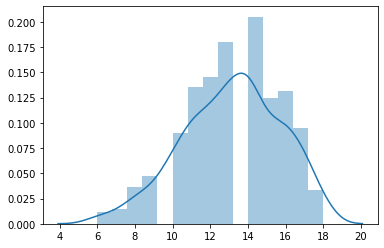

In [11]:
val_counts = [count(val_iter_policy[0]) for i in range(1000)]
print("An agent using a policy which has been value-iterated takes about an average of " + str(int(np.mean(val_counts)))
      + " steps to successfully complete its mission.")
sns.distplot(val_counts)

## Q-learning with the epsilon-greedy method
The algorithm for Q-learning is as follows:

* Initialize the Q-table by all zeros.
* Start exploring actions: For each state, select any one among all possible actions for the current state (S).
* Travel to the next state (S') as a result of that action (a).
* For all possible actions from the state (S') select the one with the highest Q-value with probability (1-epsilon) and select a random action with probability (epsilon). This is to balance the exploration and exploitation actions.
* Update Q-table values using the equation: Q(state,action) <- (1−α) Q(state,action) + α(reward + γ maxaQ(next state,all actions))
* Set the next state as the current state.
* If goal state is reached, then end and repeat the process.

In [0]:
import random
from IPython.display import clear_output

def Q_learning_train(env,alpha,gamma,epsilon,episodes): 
    """Q Learning Algorithm with epsilon greedy 

    Args:
        env: Environment 
        alpha: Learning Rate --> Extent to which our Q-values are being updated in every iteration.
        gamma: Discount Rate --> How much importance we want to give to future rewards
        epsilon: Probability of selecting random action instead of the 'optimal' action
        episodes: No. of episodes to train on

    Returns:
        Q-learning Trained policy

    """
    %%time
    """Training the agent"""

    # For plotting metrics
    all_epochs = []
    all_penalties = []
    
    #Initialize Q table of 500 x 6 size (500 states and 6 actions) with all zeroes
    q_table = np.zeros([env.observation_space.n, env.action_space.n])  
    
    for i in range(1, episodes+1):
        state = env.reset()

        epochs, penalties, reward, = 0, 0, 0
        done = False

        while not done:
            if random.uniform(0, 1) < epsilon:
                action = env.action_space.sample() # Explore action space randomly
            else:
                action = np.argmax(q_table[state]) # Exploit learned values by choosing optimal values

            next_state, reward, done, info = env.step(action) 

            old_value = q_table[state, action]
            next_max = np.max(q_table[next_state])

            new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
            q_table[state, action] = new_value

            if reward == -10:
                penalties += 1

            state = next_state
            epochs += 1

        if i % 100 == 0:
            clear_output(wait=True)
            print(f"Episode: {i}")
    # Start with a random policy
    policy = np.ones([env.env.nS, env.env.nA]) / env.env.nA

    for state in range(env.env.nS):  #for each states
        best_act = np.argmax(q_table[state]) #find best action
        policy[state] = np.eye(env.env.nA)[best_act]  #update 
        
    print("Training finished.\n")
    return policy, q_table

In [0]:
env = gym.make('Taxi-v3')
env.reset()
Q_learn_pol = Q_learning_train(env,0.2,0.95,0.1,100000)

Episode: 100000
Training finished.



An agent using a policy which has been improved using Q-learning takes about an average of 13 steps to successfully complete its mission.


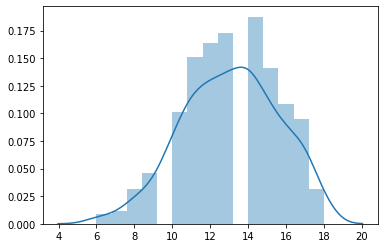

In [0]:
Q_counts = [count(Q_learn_pol[0]) for i in range(1000)]
print("An agent using a policy which has been improved using Q-learning takes about an average of " + str(int(np.mean(Q_counts)))
      + " steps to successfully complete its mission.")
sns.distplot(Q_counts)

## View the policies in action

In [0]:
def view_policy(policy):
    curr_state = env.reset()
    env.render()
    counter = 0
    reward = None
    while reward != 20:
        state, reward, done, info = env.step(np.argmax(policy[0][curr_state])) 
        curr_state = state
        counter += 1
        env.env.s = curr_state
        env.render()

In [0]:
from IPython.display import clear_output

from matplotlib import animation
from IPython.display import display


def view_policy_anim(policy):
    penalties, reward = 0, 0

    frames = [] # for animation

    done = False
    curr_state = env.reset()
    while not done:
        action = np.argmax(policy[0][curr_state])
        state, reward, done, info = env.step(action)
        curr_state = state
        if reward == -10:
            penalties += 1

        # Put each rendered frame into dict for animation
        frames.append({
            'frame': env.render(mode='ansi'),
            'state': state,
            'action': action,
            'reward': reward
            }
        )
    def print_frames(frames):
        for i, frame in enumerate(frames):
            clear_output(wait=True)
            print(frame['frame'])
            print(f"Timestep: {i + 1}")
            print(f"State: {frame['state']}")
            print(f"Action: {frame['action']}")
            print(f"Reward: {frame['reward']}")
            sleep(1.5)

    print_frames(frames)

### View value iterated policy

In [0]:
view_policy_anim(pol_iter_policy)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 17
State: 475
Action: 5
Reward: 20


### View Q-learning policy

In [0]:
view_policy_anim(Q_learn_pol)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 14
State: 410
Action: 5
Reward: 20


# Deep Q learning Space invaders:
Code snippets used from this tutorial: https://simoninithomas.github.io/Deep_reinforcement_learning_Course/
<br>and this notebook: https://github.com/simoninithomas/Deep_reinforcement_learning_Course/blob/master/Deep%20Q%20Learning/Space%20Invaders/DQN%20Atari%20Space%20Invaders.ipynb

In [0]:
import tensorflow as tf      # Deep Learning library
import numpy as np           # Handle matrices
# import retro                 # Retro Environment
import gym

from skimage import transform # Help us to preprocess the frames
from skimage.color import rgb2gray # Help us to gray our frames

import matplotlib.pyplot as plt # Display graphs

from collections import deque# Ordered collection with ends

import random
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
%matplotlib inline
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
import warnings # This ignore all the warning messages that are normally printed during the training because of skiimage
warnings.filterwarnings('ignore')

In [0]:
# Create our environment
# env = retro.make(game='SpaceInvaders-Atari2600')
env = gym.make('SpaceInvaders-v0')
print("The size of our frame is: ", env.observation_space)
print("The action size is : ", env.action_space.n)

# Here we create an hot encoded version of our actions
# possible_actions = [[1, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0]...]
possible_actions = np.array(np.identity(env.action_space.n,dtype=int).tolist())
# possible_actions = env.action_space.n

The size of our frame is:  Box(210, 160, 3)
The action size is :  6


In [0]:
# look at the action space
print(env.unwrapped.get_action_meanings())

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


## Preprocessing

In [0]:
"""
    preprocess_frame:
    Take a frame.
    Grayscale it
    Resize it.
        __________________
        |                 |
        |                 |
        |                 |
        |                 |
        |_________________|
        
        to
        _____________
        |            |
        |            |
        |            |
        |____________|
    Normalize it.
    
    return preprocessed_frame
    
    """
def preprocess_frame(frame):
    # Greyscale frame 
    gray = rgb2gray(frame)
    
    # Crop the screen (remove the part below the player)
    # [Up: Down, Left: right]
    cropped_frame = gray[8:-12,4:-12]
    
    # Normalize Pixel Values
    normalized_frame = cropped_frame/255.0
    
    # Resize
    # Thanks to Mikołaj Walkowiak
    preprocessed_frame = transform.resize(normalized_frame, [110,84])
    
    return preprocessed_frame # 110x84x1 frame

## Stacking

In [0]:
stack_size = 4 # We stack 4 frames

# Initialize deque with zero-images one array for each image
stacked_frames  =  deque([np.zeros((110,84), dtype=np.int) for i in range(stack_size)], maxlen=4)

def stack_frames(stacked_frames, state, is_new_episode):
    # Preprocess frame
    frame = preprocess_frame(state)
    
    if is_new_episode:
        # Clear our stacked_frames
        stacked_frames = deque([np.zeros((110,84), dtype=np.int) for i in range(stack_size)], maxlen=4)
        
        # Because we're in a new episode, copy the same frame 4x
        stacked_frames.append(frame)
        stacked_frames.append(frame)
        stacked_frames.append(frame)
        stacked_frames.append(frame)
        
        # Stack the frames
        stacked_state = np.stack(stacked_frames, axis=2)
        
    else:
        # Append frame to deque, automatically removes the oldest frame
        stacked_frames.append(frame)

        # Build the stacked state (first dimension specifies different frames)
        stacked_state = np.stack(stacked_frames, axis=2) 
    
    return stacked_state, stacked_frames

## Set up hyperparameters

In [0]:
### MODEL HYPERPARAMETERS
state_size = [110, 84, 4]      # Our input is a stack of 4 frames hence 110x84x4 (Width, height, channels) 
action_size = env.action_space.n # 6 possible actions
learning_rate =  0.00025      # Alpha (aka learning rate)

### TRAINING HYPERPARAMETERS
total_episodes = 100            # Total episodes for training
max_steps = 5000              # Max possible steps in an episode
batch_size = 64                # Batch size

# Exploration parameters for epsilon greedy strategy
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.00001           # exponential decay rate for exploration prob

# Q learning hyperparameters
gamma = 0.9                    # Discounting rate

### MEMORY HYPERPARAMETERS
pretrain_length = batch_size   # Number of experiences stored in the Memory when initialized for the first time
memory_size = 1000000          # Number of experiences the Memory can keep

### PREPROCESSING HYPERPARAMETERS
stack_size = 4                 # Number of frames stacked

### MODIFY THIS TO FALSE IF YOU JUST WANT TO SEE THE TRAINED AGENT
training = True

## TURN THIS TO TRUE IF YOU WANT TO RENDER THE ENVIRONMENT
episode_render = False

## Create the Deep Q-learning Model
* We take a stack of 4 frames as input
* It passes through 3 convnets
* Then it is flatened
* Finally it passes through 2 FC layers
* It outputs a Q value for each actions

In [0]:
class DQNetwork:
    def __init__(self, state_size, action_size, learning_rate, name='DQNetwork'):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        
        with tf.variable_scope(name):
            # We create the placeholders
            # *state_size means that we take each elements of state_size in tuple hence is like if we wrote
            # [None, 84, 84, 4]
            self.inputs_ = tf.placeholder(tf.float32, [None, *state_size], name="inputs")
            self.actions_ = tf.placeholder(tf.float32, [None, self.action_size], name="actions_")
            
            # Remember that target_Q is the R(s,a) + ymax Qhat(s', a')
            self.target_Q = tf.placeholder(tf.float32, [None], name="target")
            
            """
            First convnet:
            CNN
            ELU
            """
            # Input is 110x84x4
            self.conv1 = tf.layers.conv2d(inputs = self.inputs_,
                                         filters = 32,
                                         kernel_size = [8,8],
                                         strides = [4,4],
                                         padding = "VALID",
                                          kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                         name = "conv1")
            
            self.conv1_out = tf.nn.elu(self.conv1, name="conv1_out")
            
            """
            Second convnet:
            CNN
            ELU
            """
            self.conv2 = tf.layers.conv2d(inputs = self.conv1_out,
                                 filters = 64,
                                 kernel_size = [4,4],
                                 strides = [2,2],
                                 padding = "VALID",
                                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                 name = "conv2")

            self.conv2_out = tf.nn.elu(self.conv2, name="conv2_out")            
            
            """
            Third convnet:
            CNN
            ELU
            """
            self.conv3 = tf.layers.conv2d(inputs = self.conv2_out,
                                 filters = 64,
                                 kernel_size = [3,3],
                                 strides = [2,2],
                                 padding = "VALID",
                                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                 name = "conv3")

            self.conv3_out = tf.nn.elu(self.conv3, name="conv3_out")
            
            self.flatten = tf.contrib.layers.flatten(self.conv3_out)
            
            self.fc = tf.layers.dense(inputs = self.flatten,
                                  units = 512,
                                  activation = tf.nn.elu,
                                       kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                name="fc1")
            
            self.output = tf.layers.dense(inputs = self.fc, 
                                           kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                          units = self.action_size, 
                                        activation=None)
            

  
            # Q is our predicted Q value.
            self.Q = tf.reduce_sum(tf.multiply(self.output, self.actions_))
            
            # The loss is the difference between our predicted Q_values and the Q_target
            # Sum(Qtarget - Q)^2
            self.loss = tf.reduce_mean(tf.square(self.target_Q - self.Q))
            
            self.optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)

In [0]:
# Reset the graph
tf.reset_default_graph()

# Instantiate the DQNetwork
DQNetwork = DQNetwork(state_size, action_size, learning_rate)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.Dense instead.


## Set up Experience Replay

In [0]:
class Memory():
    def __init__(self, max_size):
        self.buffer = deque(maxlen = max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
    
    def sample(self, batch_size):
        buffer_size = len(self.buffer)
        index = np.random.choice(np.arange(buffer_size),
                                size = batch_size,
                                replace = False)
        
        return [self.buffer[i] for i in index]

In [0]:
# Instantiate memory
memory = Memory(max_size = memory_size)
for i in range(pretrain_length):
    # If it's the first step
    if i == 0:
        state = env.reset()
        
        state, stacked_frames = stack_frames(stacked_frames, state, True)
        
    # Get the next_state, the rewards, done by taking a random action
    choice = random.randint(1,len(possible_actions))-1
    action = possible_actions[choice]
    next_state, reward, done, _ = env.step(np.where(action==1)[0][0])
    
    #env.render()
    
    # Stack the frames
    next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)
    
    
    # If the episode is finished (we're dead 3x)
    if done:
        # We finished the episode
        next_state = np.zeros(state.shape)
        
        # Add experience to memory
        memory.add((state, action, reward, next_state, done))
        
        # Start a new episode
        state = env.reset()
        
        # Stack the frames
        state, stacked_frames = stack_frames(stacked_frames, state, True)
        
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state, done))
        
        # Our new state is now the next_state
        state = next_state

## Set up Tensorboard

In [0]:
# Setup TensorBoard Writer
writer = tf.summary.FileWriter("/tensorboard/dqn/1")

## Losses
tf.summary.scalar("Loss", DQNetwork.loss)

write_op = tf.summary.merge_all()

## Create a function to display/save the environment state

In [0]:
# https://stackoverflow.com/questions/40195740/how-to-run-openai-gym-render-over-a-server
from time import sleep
def show_state(env, episode=0, step=0, info=""):
    # sleep(0.4)
    %matplotlib inline
    fig = plt.figure(3)
    _ = plt.clf()
    _ = plt.imshow(env.render(mode='rgb_array'))
    _ = plt.title("Space Invaders | Episode : {:03d} Step: {:06d}".format(episode, step))
    _ = plt.axis('off')
    # import os
    # img = plt.imsave("/content/images/SI_E{:02d}_S{:04d}.png".format(episode,step), env.render(mode='rgb_array'))
    _ = plt.savefig("/content/images/SI_E{:03d}_S{:06d}.png".format(episode,step), bbox_inches='tight', pad_inches=0)
    _ = plt.close(fig)
    # display.clear_output(wait=True)
    # display.display(plt.gcf())

## Train the agent

In [0]:
saver = tf.train.Saver()
"""
This function will do the part
With ϵϵ select a random action atat, otherwise select at=argmaxaQ(st,a)
"""
def predict_action(explore_start, explore_stop, decay_rate, decay_step, state, actions):
    ## EPSILON GREEDY STRATEGY
    # Choose action a from state s using epsilon greedy.
    ## First we randomize a number
    exp_exp_tradeoff = np.random.rand()

    # Here we'll use an improved version of our epsilon greedy strategy used in Q-learning notebook
    explore_probability = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * decay_step)
    
    if (explore_probability > exp_exp_tradeoff):
        # Make a random action (exploration)
        choice = random.randint(1,len(possible_actions))-1
        action = possible_actions[choice]
        
    else:
        # Get action from Q-network (exploitation)
        # Estimate the Qs values state
        Qs = sess.run(DQNetwork.output, feed_dict = {DQNetwork.inputs_: state.reshape((1, *state.shape))})
        
        # Take the biggest Q value (= the best action)
        choice = np.argmax(Qs)
        action = possible_actions[choice]
                
                
    return action, explore_probability

In [0]:

# Saver will help us to save our model
# saver = tf.train.Saver()

if training == True:
    with tf.Session() as sess:
        # Initialize the variables
        sess.run(tf.global_variables_initializer())

        # Initialize the decay rate (that will use to reduce epsilon) 
        decay_step = 0
        
        for episode in range(total_episodes):
            # Set step to 0
            step = 0
            
            # Initialize the rewards of the episode
            episode_rewards = []
            
            # Make a new episode and observe the first state
            state = env.reset()
            
            # Remember that stack frame function also call our preprocess function.
            state, stacked_frames = stack_frames(stacked_frames, state, True)
            
            while step < max_steps:
                step += 1
                
                #Increase decay_step
                decay_step +=1
                
                # Predict the action to take and take it
                action, explore_probability = predict_action(explore_start, explore_stop, decay_rate, decay_step, state, possible_actions)
                
                #Perform the action and get the next_state, reward, and done information
                next_state, reward, done, _ = env.step(np.where(action==1)[0][0])
                
                if episode_render:
                    # env.render()
                    show_state(env, episode, step)
                
                # Add the reward to total reward
                episode_rewards.append(reward)
                
                # If the game is finished
                if done:
                    # The episode ends so no next state
                    next_state = np.zeros((110,84), dtype=np.int)
                    
                    next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)

                    # Set step = max_steps to end the episode
                    step = max_steps

                    # Get the total reward of the episode
                    total_reward = np.sum(episode_rewards)

                    print('Episode: {}'.format(episode),
                                  'Total reward: {}'.format(total_reward),
                                  'Explore P: {:.4f}'.format(explore_probability),
                                'Training Loss {:.4f}'.format(loss))

                    # rewards_list.append((episode, total_reward))

                    # Store transition <st,at,rt+1,st+1> in memory D
                    memory.add((state, action, reward, next_state, done))

                else:
                    # Stack the frame of the next_state
                    next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)
                
                    # Add experience to memory
                    memory.add((state, action, reward, next_state, done))

                    # st+1 is now our current state
                    state = next_state
                    

                ### LEARNING PART            
                # Obtain random mini-batch from memory
                batch = memory.sample(batch_size)
                states_mb = np.array([each[0] for each in batch], ndmin=3)
                actions_mb = np.array([each[1] for each in batch])
                rewards_mb = np.array([each[2] for each in batch]) 
                next_states_mb = np.array([each[3] for each in batch], ndmin=3)
                dones_mb = np.array([each[4] for each in batch])

                target_Qs_batch = []

                # Get Q values for next_state 
                Qs_next_state = sess.run(DQNetwork.output, feed_dict = {DQNetwork.inputs_: next_states_mb})
                
                # Set Q_target = r if the episode ends at s+1, otherwise set Q_target = r + gamma*maxQ(s', a')
                for i in range(0, len(batch)):
                    terminal = dones_mb[i]

                    # If we are in a terminal state, only equals reward
                    if terminal:
                        target_Qs_batch.append(rewards_mb[i])
                        
                    else:
                        target = rewards_mb[i] + gamma * np.max(Qs_next_state[i])
                        target_Qs_batch.append(target)
                        

                targets_mb = np.array([each for each in target_Qs_batch])

                loss, _ = sess.run([DQNetwork.loss, DQNetwork.optimizer],
                                        feed_dict={DQNetwork.inputs_: states_mb,
                                                   DQNetwork.target_Q: targets_mb,
                                                   DQNetwork.actions_: actions_mb})

                # Write TF Summaries
                summary = sess.run(write_op, feed_dict={DQNetwork.inputs_: states_mb,
                                                       DQNetwork.target_Q: targets_mb,
                                                       DQNetwork.actions_: actions_mb})
                writer.add_summary(summary, episode)
                writer.flush()

            # Save model every 5 episodes
            if episode % 5 == 0:
                save_path = saver.save(sess, "./models/model.ckpt")
                print("Model Saved")
        save_path = saver.save(sess, "./models/model.ckpt")
        print("Model Saved")

Episode: 0 Total reward: 50.0 Explore P: 0.9948 Training Loss 0.0072
Model Saved
Episode: 1 Total reward: 135.0 Explore P: 0.9882 Training Loss 0.0020
Episode: 2 Total reward: 410.0 Explore P: 0.9765 Training Loss 0.0212
Episode: 3 Total reward: 20.0 Explore P: 0.9722 Training Loss 13.8484
Episode: 4 Total reward: 110.0 Explore P: 0.9662 Training Loss 3.4729
Episode: 5 Total reward: 105.0 Explore P: 0.9615 Training Loss 0.1214
Model Saved
Episode: 6 Total reward: 130.0 Explore P: 0.9542 Training Loss 0.0031
Episode: 7 Total reward: 80.0 Explore P: 0.9493 Training Loss 0.0075
Episode: 8 Total reward: 110.0 Explore P: 0.9427 Training Loss 0.0558
Episode: 9 Total reward: 45.0 Explore P: 0.9386 Training Loss 15.7963
Episode: 10 Total reward: 90.0 Explore P: 0.9344 Training Loss 0.0122
Model Saved
Episode: 11 Total reward: 210.0 Explore P: 0.9255 Training Loss 0.3865
Episode: 12 Total reward: 50.0 Explore P: 0.9217 Training Loss 13.8939
Episode: 13 Total reward: 120.0 Explore P: 0.9155 Trai

## Download Model Checkpoints

In [0]:
# !zip -r /content/models.zip /content/models

In [0]:
# from google.colab import files
# files.download("/content/models.zip")

## Test and watch the Agent

In [0]:
import os
import shutil

if os.path.isdir('/content/images/'):
  shutil.rmtree('/content/images/')
if not os.path.isdir('/content/images/'):
  os.makedirs('/content/images/')
with tf.Session() as sess:
    total_test_rewards = []
    
    # Load the model
    saver.restore(sess, "./models/model.ckpt")
    
    for episode in range(1):
        total_rewards = 0
        
        state = env.reset()
        state, stacked_frames = stack_frames(stacked_frames, state, True)
        
        print("****************************************************")
        print("EPISODE ", episode)
        step = 0
        while True:
            # Reshape the state
            state = state.reshape((1, *state_size))
            # Get action from Q-network 
            # Estimate the Qs values state
            Qs = sess.run(DQNetwork.output, feed_dict = {DQNetwork.inputs_: state})
            
            # Take the biggest Q value (= the best action)
            choice = np.argmax(Qs)
            action = possible_actions[choice]
            
            #Perform the action and get the next_state, reward, and done information
            next_state, reward, done, _ = env.step(np.where(action==1)[0][0])
            # env.render()
            show_state(env, episode, step)
            step += 1
            
            total_rewards += reward

            if done:
                print ("Score", total_rewards)
                total_test_rewards.append(total_rewards)
                break
                
                
            next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)
            state = next_state
            
    env.close()

INFO:tensorflow:Restoring parameters from ./models/model.ckpt
****************************************************
EPISODE  0
Score 20.0


### Create an avi file from the images and convert it to mp4

In [0]:
import os

def convert_avi_to_mp4(avi_file_path, output_name):
    os.popen("ffmpeg -i '{input}' -ac 2 -b:v 2000k -c:a aac -c:v libx264 -b:a 160k -vprofile high -bf 0 -strict experimental -f mp4 '{output}'".format(input = avi_file_path, output = output_name))
    return True

In [0]:
import cv2
import numpy as np
import glob
if os.path.isfile('/content/video.avi'):
    os.remove("/content/video.avi")
if os.path.isfile('/content/video.mp4'):
    os.remove("/content/video.mp4")
img_array = []
for filename in sorted(glob.glob('/content/images/SI_E000_S*.png')):
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)
img_array = [cv2.resize(img_sized, size, interpolation=cv2.INTER_AREA) for img_sized in img_array]
print(len(img_array), " Images")
out = cv2.VideoWriter('video.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()
convert_avi_to_mp4("/content/video.avi", "video.mp4")

757  Images


True

In [0]:
# from google.colab import files
# files.download("/content/video.mp4")

In [0]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)